In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [4]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 512
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.1,0.9]
args.save_model = ""
args.dataset = "dataDIVAT1"
args.loss_wrapper="rhc_rank"
args.weight = 1 / args.batch_size
args.sigma = 1.0

In [5]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
# 7. dataDIVAT1
# 8. prostate
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [6]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [7]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([4754, 19])

In [8]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

<All keys matched successfully>

In [9]:
wrapper = loss_wrapper(args.loss_wrapper)

# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(wrapper(clf_robust,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(wrapper(clf_fragile,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)

In [10]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1583.4448 Time=0.0816
[ 1:   9]: eps=0.00000000 Loss=1386.7584 Time=0.0234
Epoch time: 0.2617, Total time: 0.2617
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=1046.3444 Time=0.0079
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1280.1626 Time=0.0160
[ 2:   9]: eps=0.00000000 Loss=1052.9533 Time=0.0158
Epoch time: 0.1790, Total time: 0.4407
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=784.3482 Time=0.0076
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=892.4095 Time=0.0150
[ 3:   9]: eps=0.00000000 Loss=772.3842 Time=0.0143
Epoch time: 0.1630, Total time: 0.6037
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=573.2650 Time=0.0068
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=595.2966 Time=0.0149
[ 4:   9]: eps=0.00000000 Loss=565.5774 Time=0.0143
Epoch time: 0.1622, Total time: 0.7660
Evaluating...
[ 4:   2]: eps=0.00000000 Loss=430.4627 Time=0.0071
Epoch 5, learning rate [0.001]
[ 5:

In [11]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=1583.4448 Time=0.1060
[ 1:   9]: eps=0.00000000 Loss=1386.7584 Time=0.0323
Epoch time: 0.3702, Total time: 0.3702
Evaluating...
[ 1:   2]: eps=0.00000000 Loss=1046.3444 Time=0.0135
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=1280.1626 Time=0.0248
[ 2:   9]: eps=0.00000000 Loss=1052.9533 Time=0.0238
Epoch time: 0.2947, Total time: 0.6650
Evaluating...
[ 2:   2]: eps=0.00000000 Loss=784.3482 Time=0.0109
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=892.4095 Time=0.0217
[ 3:   9]: eps=0.00000000 Loss=772.3842 Time=0.0238
Epoch time: 0.2957, Total time: 0.9607
Evaluating...
[ 3:   2]: eps=0.00000000 Loss=573.2650 Time=0.0121
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=595.2966 Time=0.0226
[ 4:   9]: eps=0.00000000 Loss=565.5774 Time=0.0251
Epoch time: 0.3096, Total time: 1.2703
Evaluating...
[ 4:   2]: eps=0.00000000 Loss=430.4627 Time=0.0136
Epoch 5, learning rate [0.001]
[ 5:

In [12]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),1000)

In [13]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 4754 total observations, 3973 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_36548\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


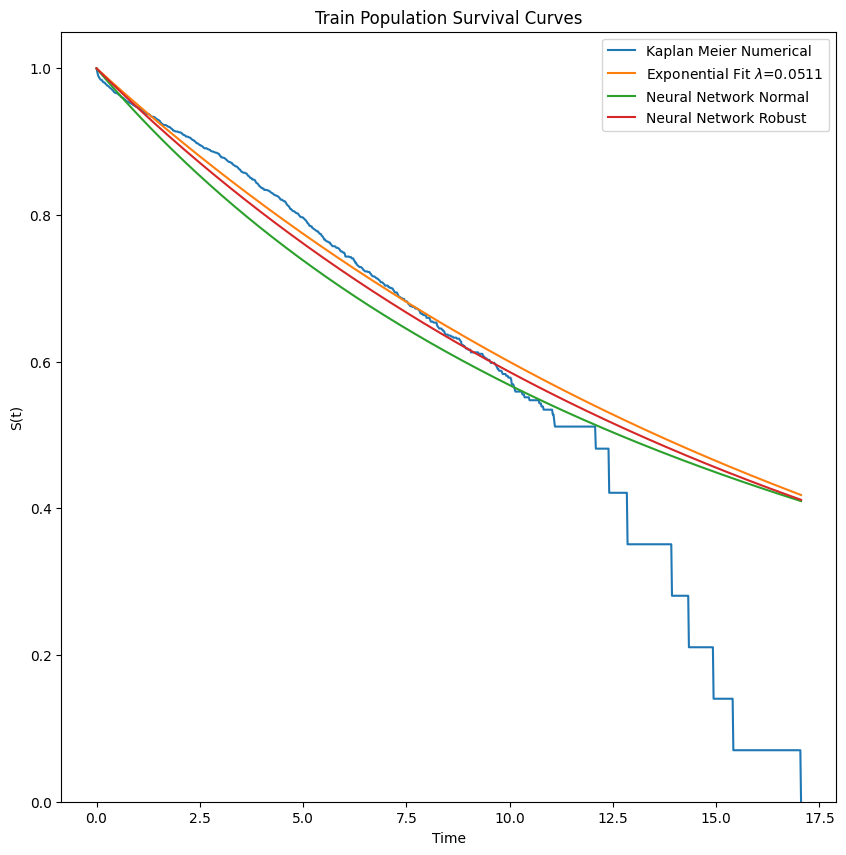

In [14]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

In [15]:
print("Exponential rate parameters: ",1/clf_exp.params_.item())

Exponential rate parameters:  0.051105964973249006


<Axes: ylabel='Count'>

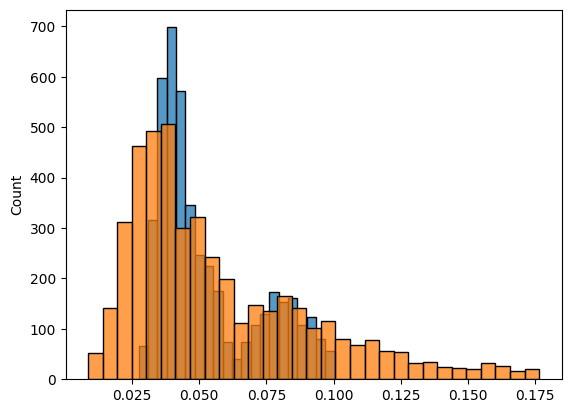

In [16]:
rates = clf_robust(X_train).detach()
rates = rates[rates < rates.quantile(0.95)]

rates_ = clf_fragile(X_train).detach()
rates_ = rates_[rates_ < rates_.quantile(0.95)]
sns.histplot(rates)
sns.histplot(rates_)

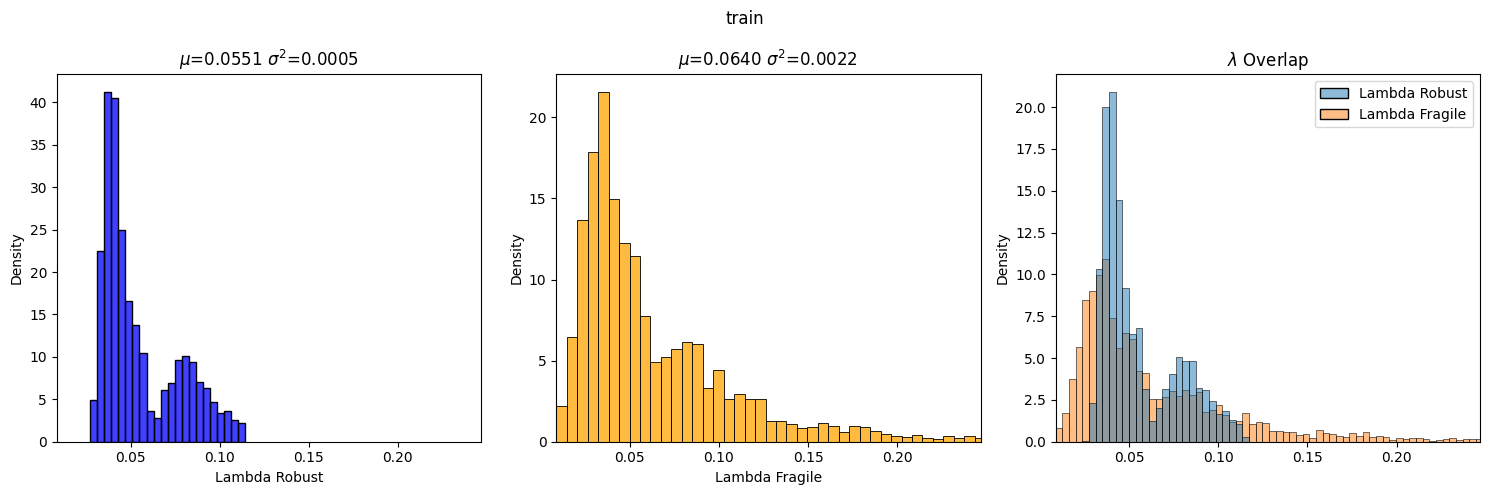

In [17]:
visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader_train,suptitle="train")

torch.Size([4754, 1000])


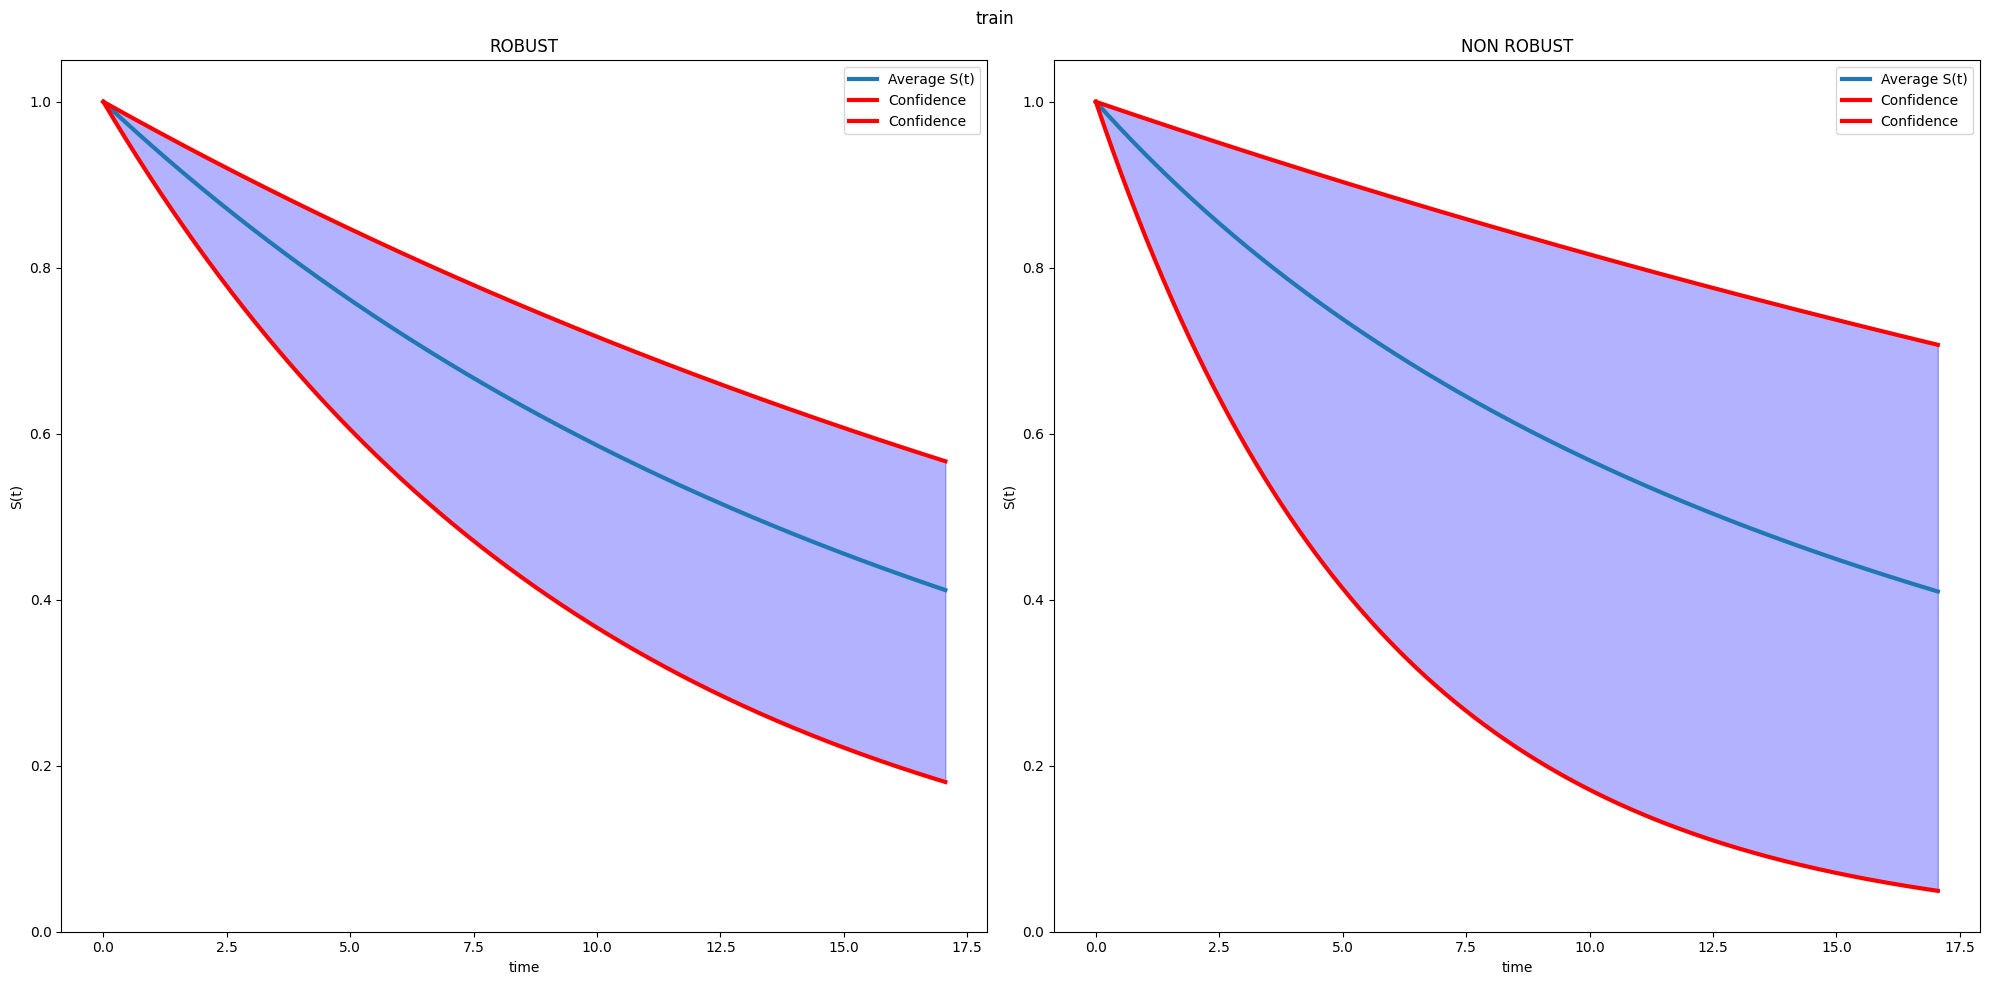

In [18]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_train,suptitle="train")

torch.Size([1189, 1000])


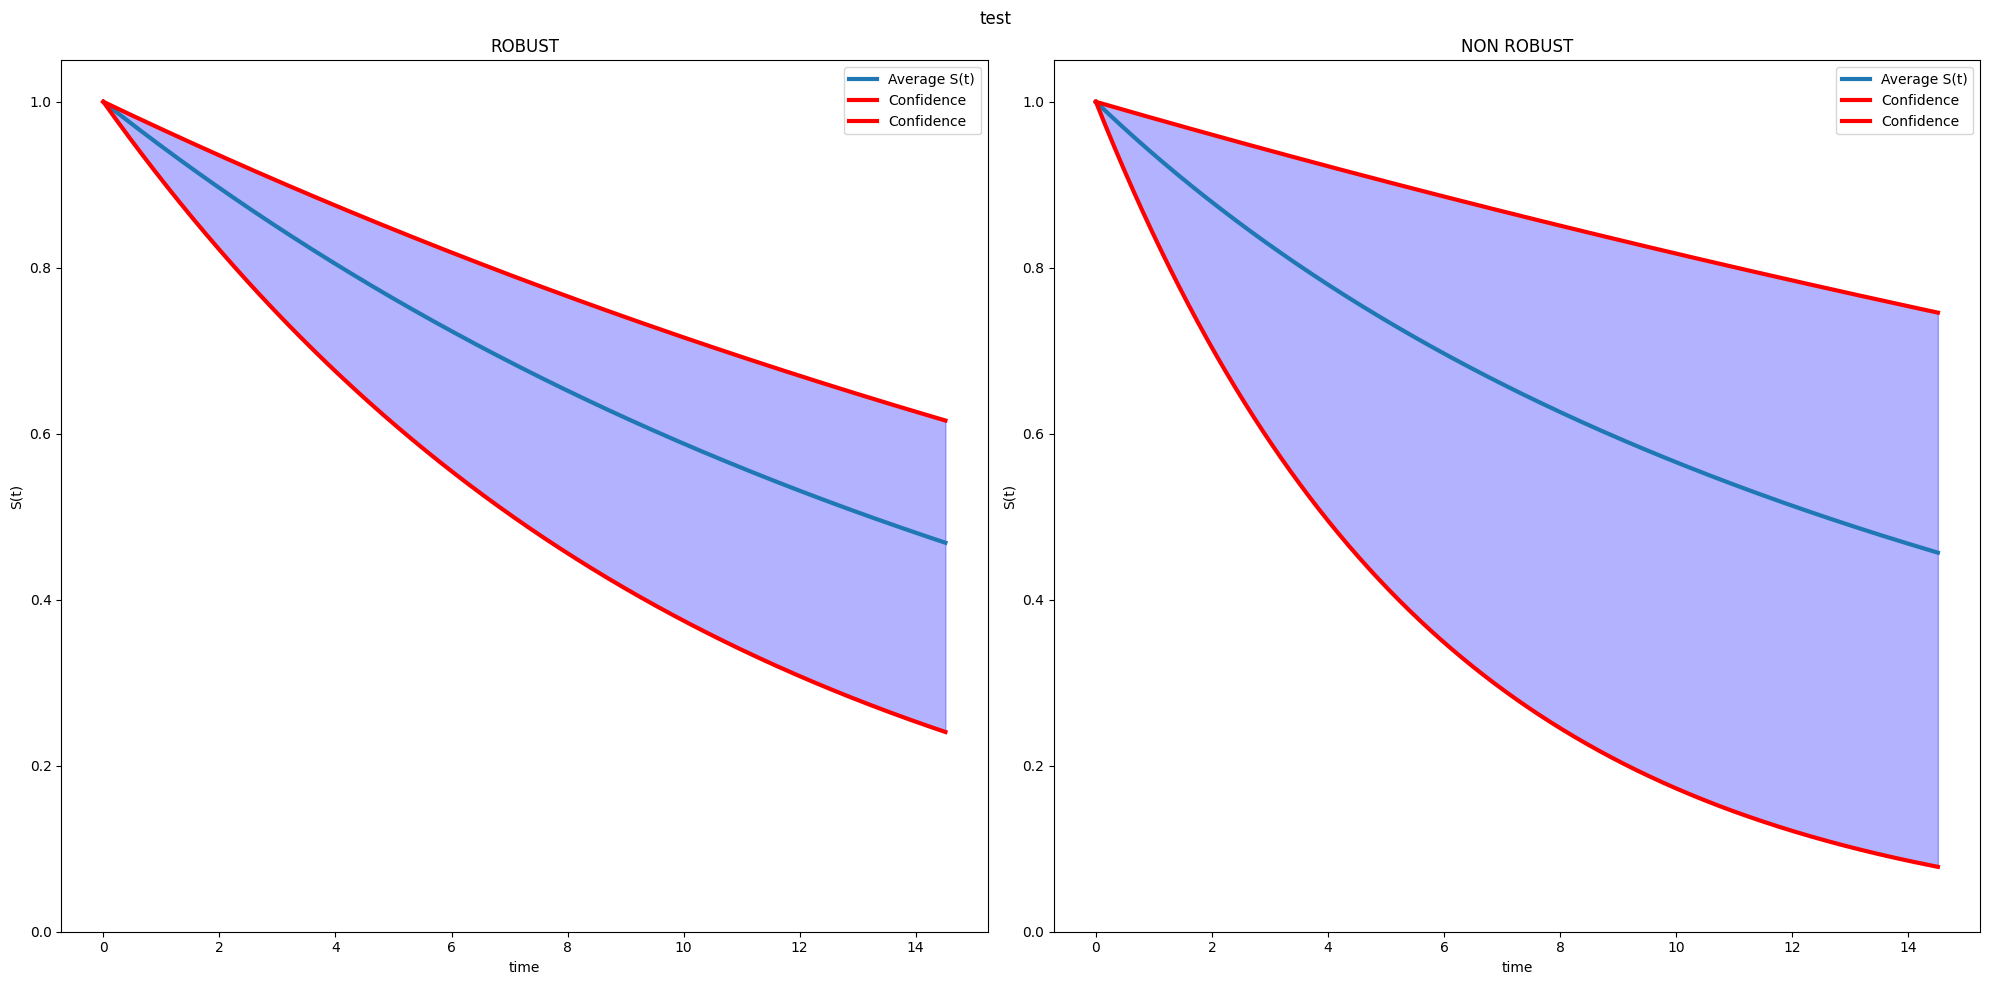

In [19]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_test,suptitle="test")

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\lifelines\fitters\__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


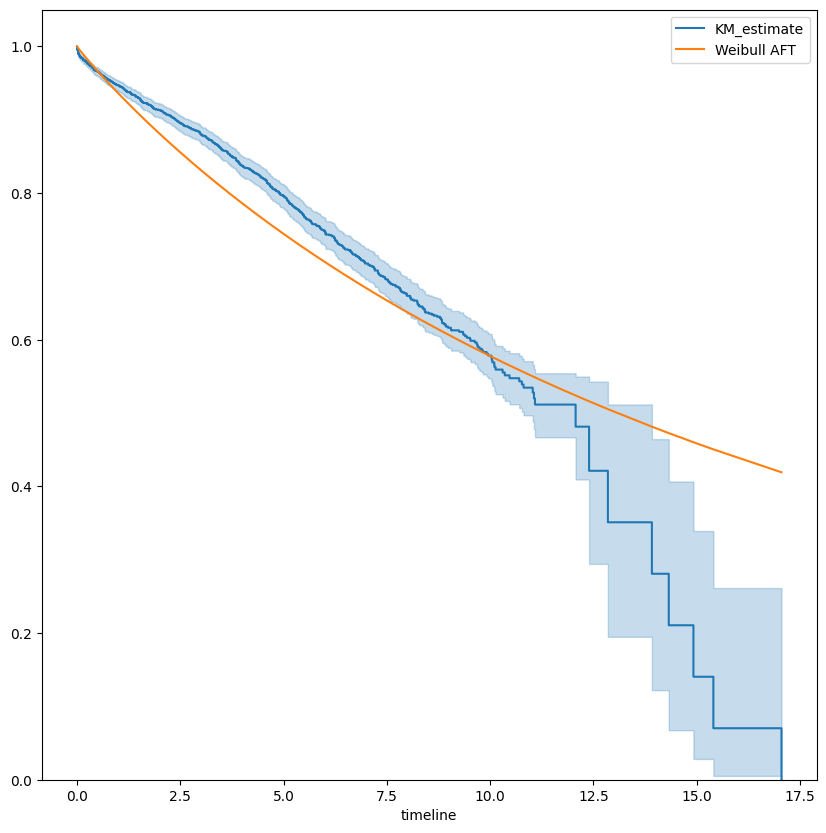

param    covariate       
lambda_  fac_graft_Yes      -0.347605
         fac_sexR_male       0.056768
         fac_year_tx_2001    0.053742
         fac_year_tx_2002    0.001851
         fac_year_tx_2003    0.040542
         fac_year_tx_2004    0.041595
         fac_year_tx_2005    0.021751
         fac_year_tx_2006    0.025276
         fac_year_tx_2007    0.073759
         fac_year_tx_2008    0.002187
         fac_year_tx_2009    0.125692
         fac_year_tx_2010   -0.048032
         fac_year_tx_2011   -0.064663
         fac_year_tx_2012   -0.207061
         num_ageR           -0.237233
         num_year_tx        -0.086286
         Intercept           2.985765
rho_     Intercept          -0.044984
dtype: float64


In [20]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
# clf_cph._scipy_fit_method = "SLSQP"
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [21]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

Lifelines CPH Train CI: 0.651
Lifelines CPH Test CI: 0.653


ROBUST CLF
CI @ eps=1 0.6513334674029186
CI @ eps=0.8 0.6541343910292909
CI @ eps=0.7 0.6535795367815062
CI @ eps=0.6 0.6525528141286728
CI @ eps=0.5 0.6519373862730513
CI @ eps=0.1 0.6499323998536541
CI @ eps=0.07 0.6498206415471953
CI @ eps=0.05 0.649747650349752
CI @ eps=0 0.6495011157658563
NONROBUST CLF
CI @ eps=1 0.5688219160159043
CI @ eps=0.8 0.5917096537370281
CI @ eps=0.7 0.6052230199093335
CI @ eps=0.6 0.6182469513303176
CI @ eps=0.5 0.6323860428715767
CI @ eps=0.1 0.670451103772282
CI @ eps=0.07 0.6714566256623724
CI @ eps=0.05 0.6716353178054909
CI @ eps=0 0.6724906171481461


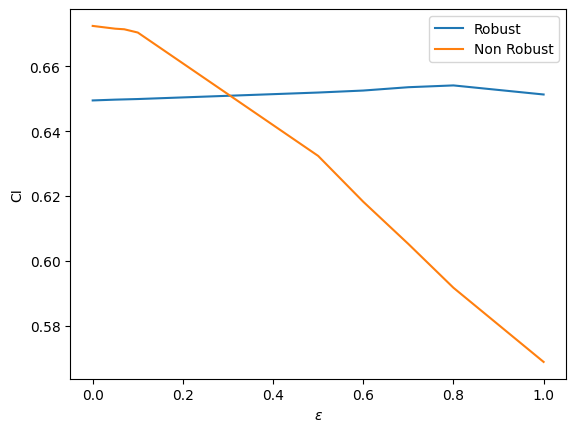

In [28]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
plt.legend(["Robust","Non Robust"])

<>:7: DeprecationWarning: invalid escape sequence '\e'


ROBUST CLF
CI @ eps=1 0.6602318741312274
CI @ eps=0.8 0.6634601825177784
CI @ eps=0.7 0.6639638187715304
CI @ eps=0.6 0.6628457462882008
CI @ eps=0.5 0.6617276738048712
CI @ eps=0.1 0.6578093837506799
CI @ eps=0.07 0.6576985837748545
CI @ eps=0.05 0.6576885110497794
CI @ eps=0 0.6571848747960273
NONROBUST CLF
CI @ eps=1 0.5466165716472935
CI @ eps=0.8 0.5750216563589113
CI @ eps=0.7 0.5905840165998509
CI @ eps=0.6 0.6095711033663047
CI @ eps=0.5 0.6265839360180503
CI @ eps=0.1 0.6337053526461048
CI @ eps=0.07 0.6331714982171277
CI @ eps=0.05 0.6330002618908519
CI @ eps=0 0.6325671347126252


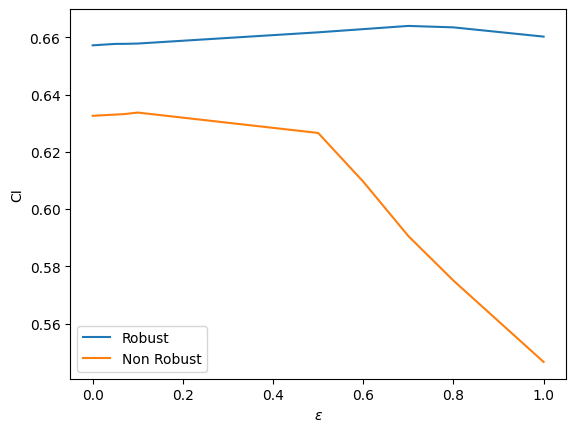

In [27]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.ylabel("CI")
plt.xlabel("$\epsilon$")
plt.legend(["Robust","Non Robust"])

<Figure size 1000x1000 with 0 Axes>

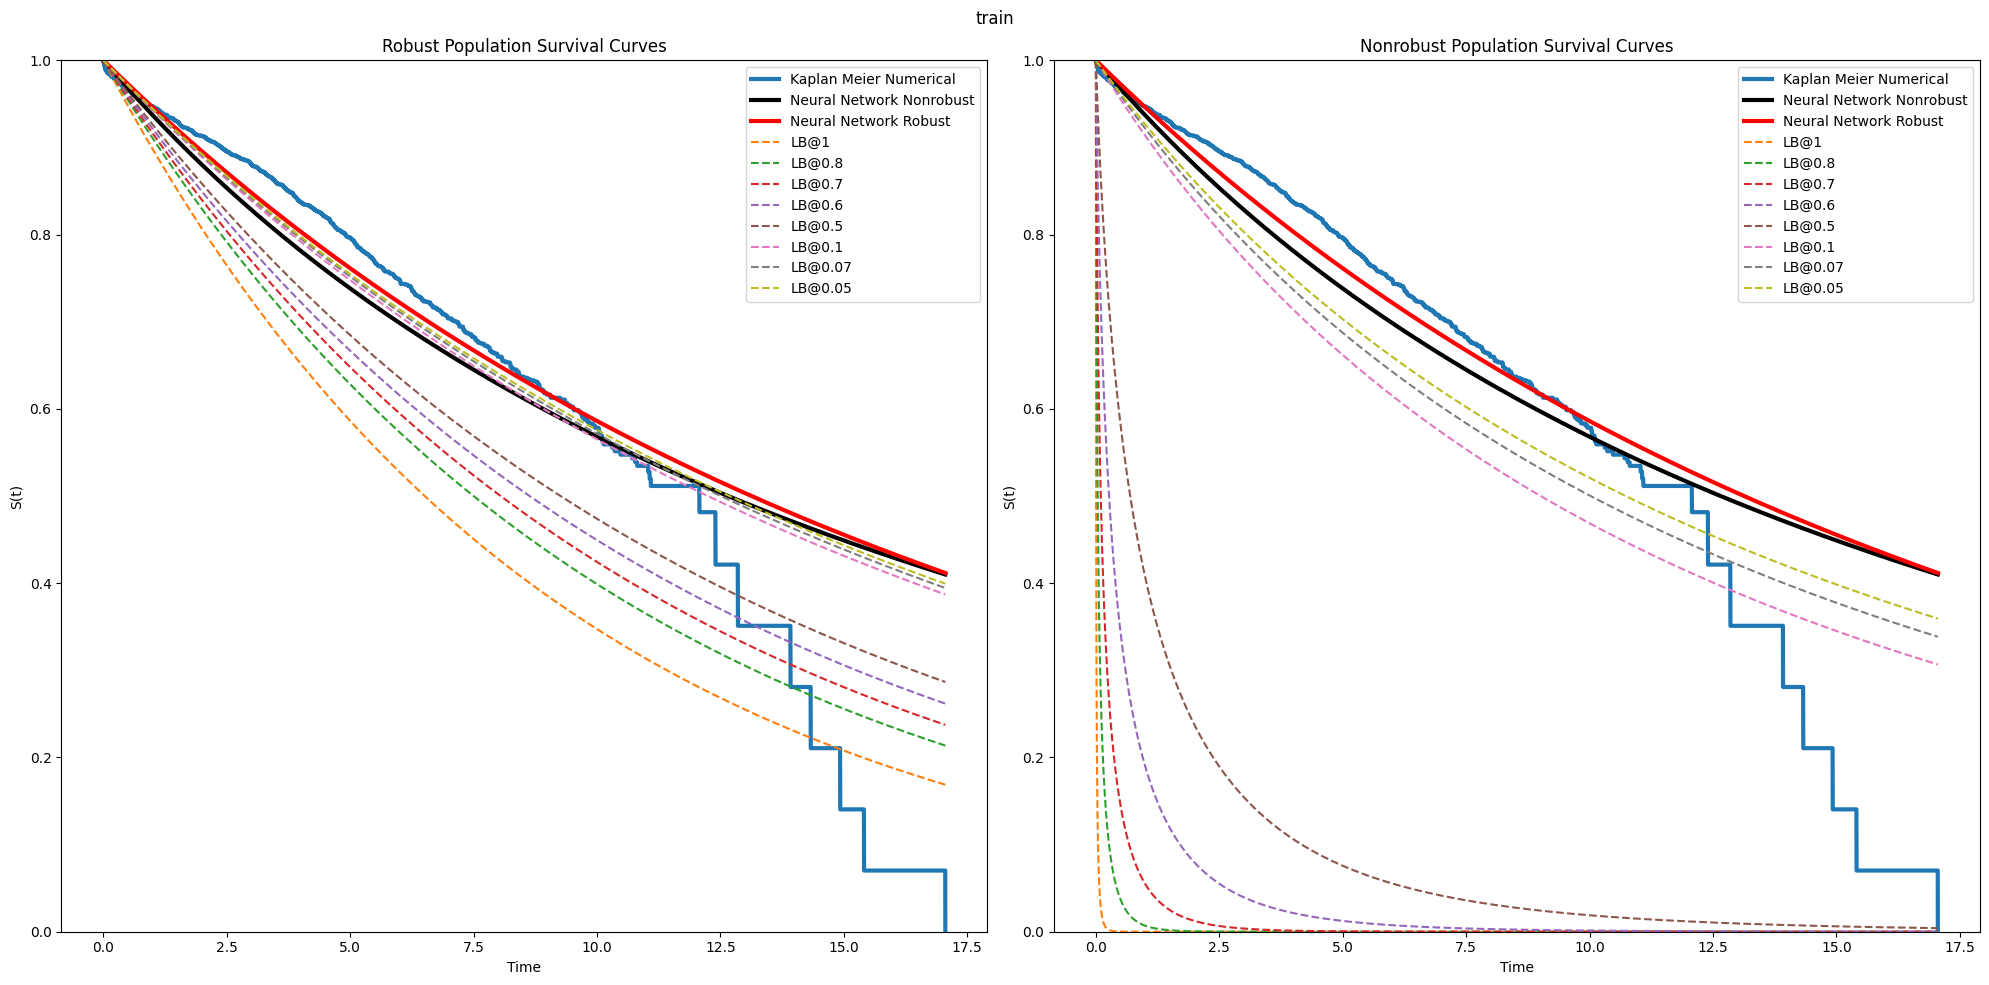

<Figure size 1000x1000 with 0 Axes>

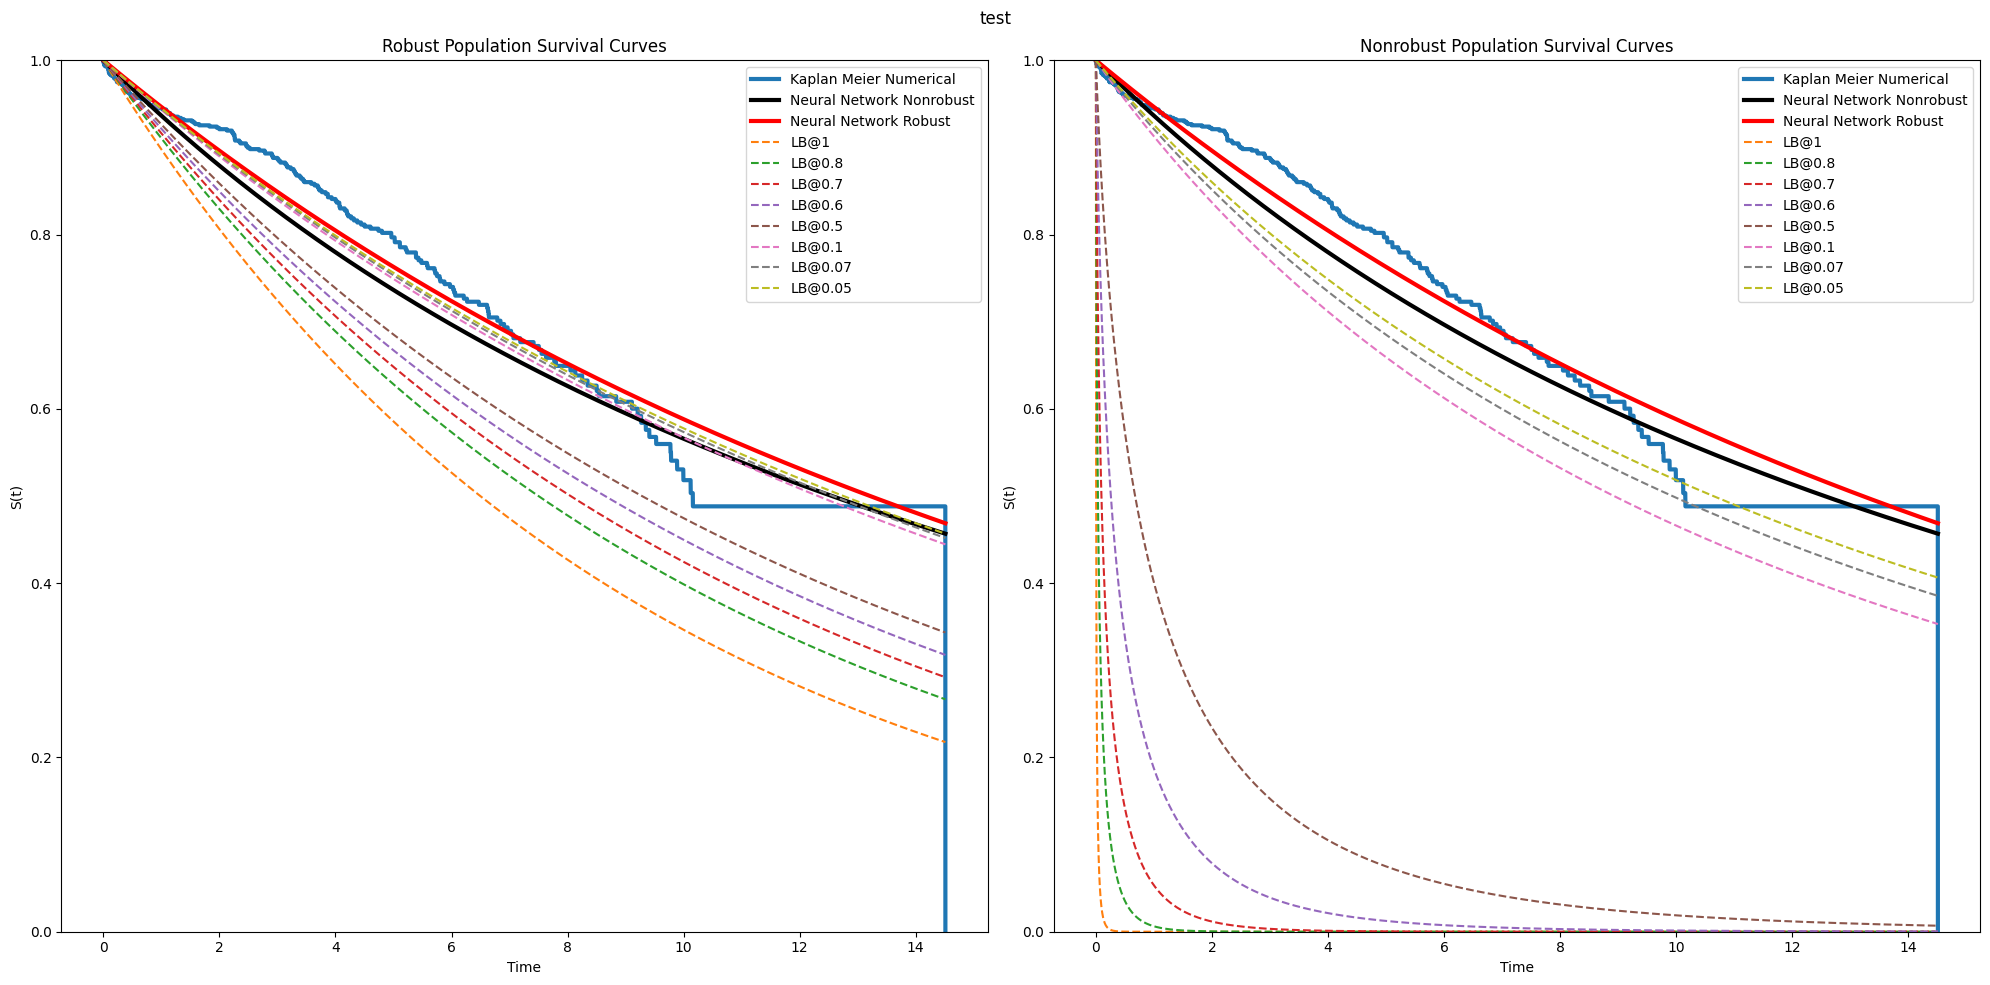

In [24]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons,suptitle="train")
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons,suptitle="test")

tensor([0.0025, 0.0031, 0.0055, 0.0088, 0.0105, 0.0114, 0.0141, 0.0180, 0.0227,
        0.0266])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]


tensor([45.3354, 45.3302, 45.3161, 45.2908, 45.2419, 45.2310, 45.2218, 45.1682,
        45.1394, 45.1242])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.09it/s]


tensor([0.0141, 0.0189, 0.0202, 0.0203, 0.0275, 0.0317, 0.0397, 0.0499, 0.0927,
        0.1050])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.21it/s]


tensor([45.9121, 45.8707, 45.7813, 45.5664, 45.3587, 45.3144, 45.2656, 45.1054,
        44.9296, 44.8066])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.25it/s]


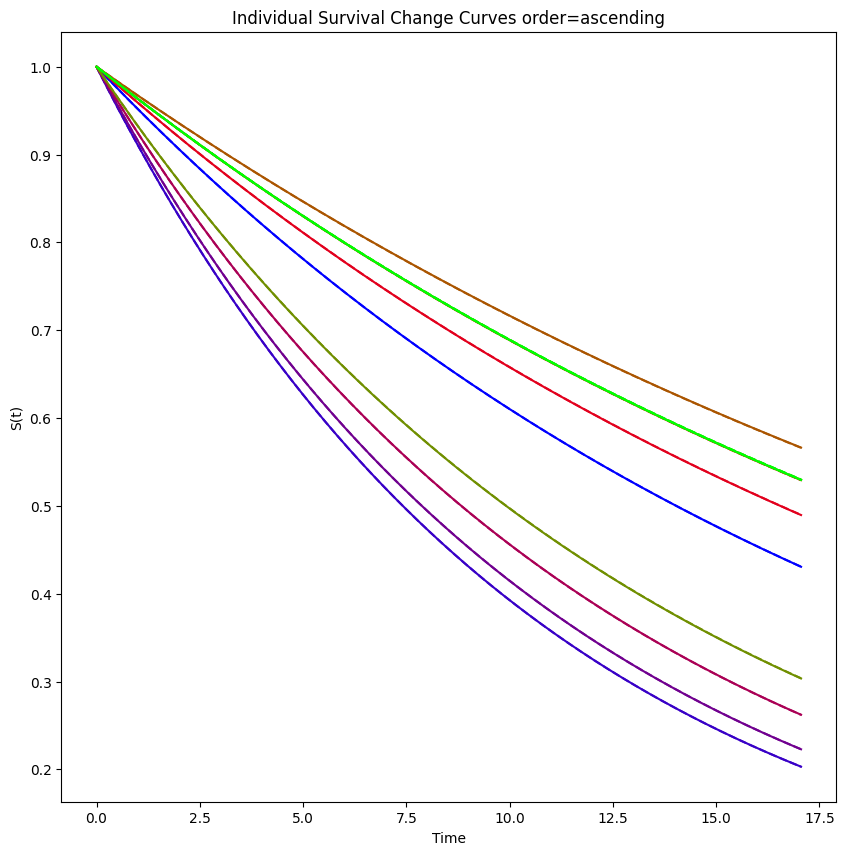

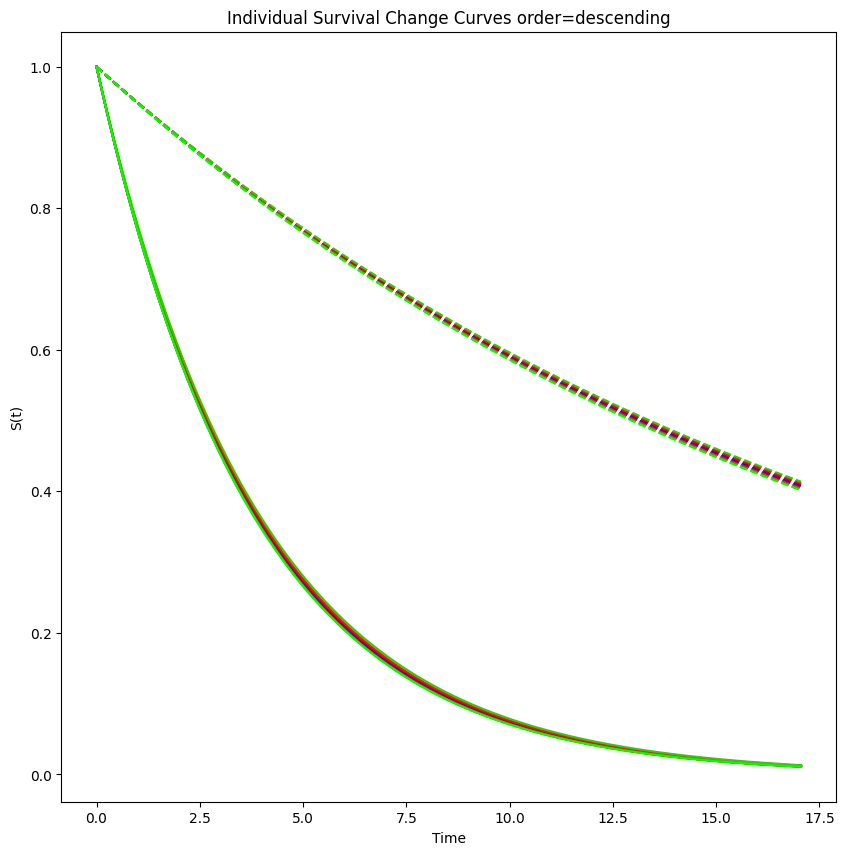

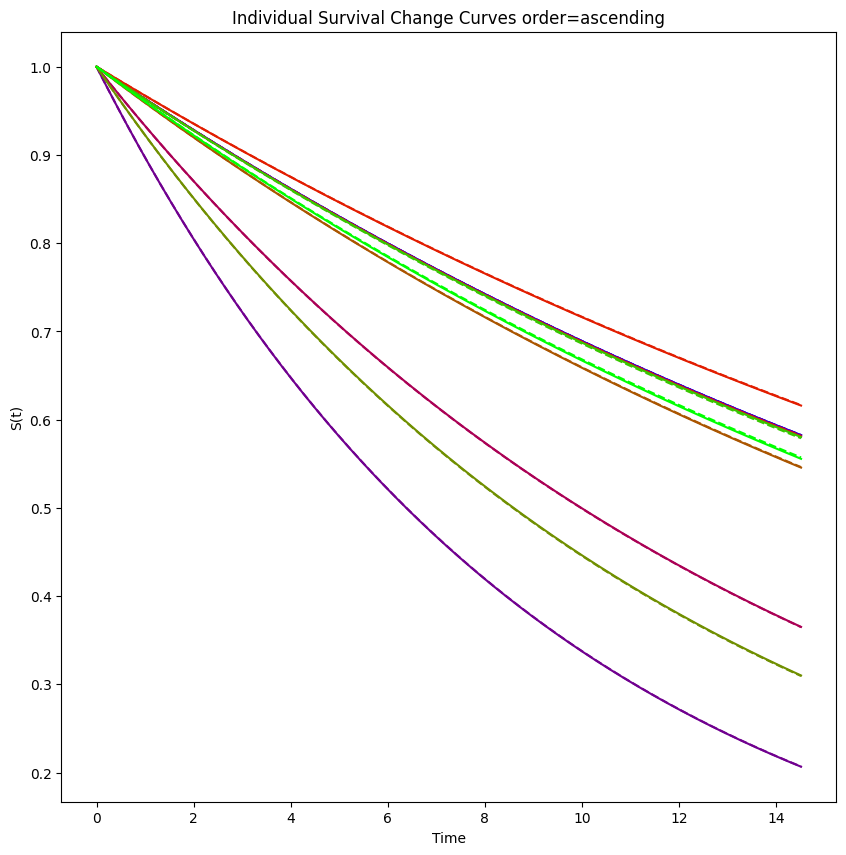

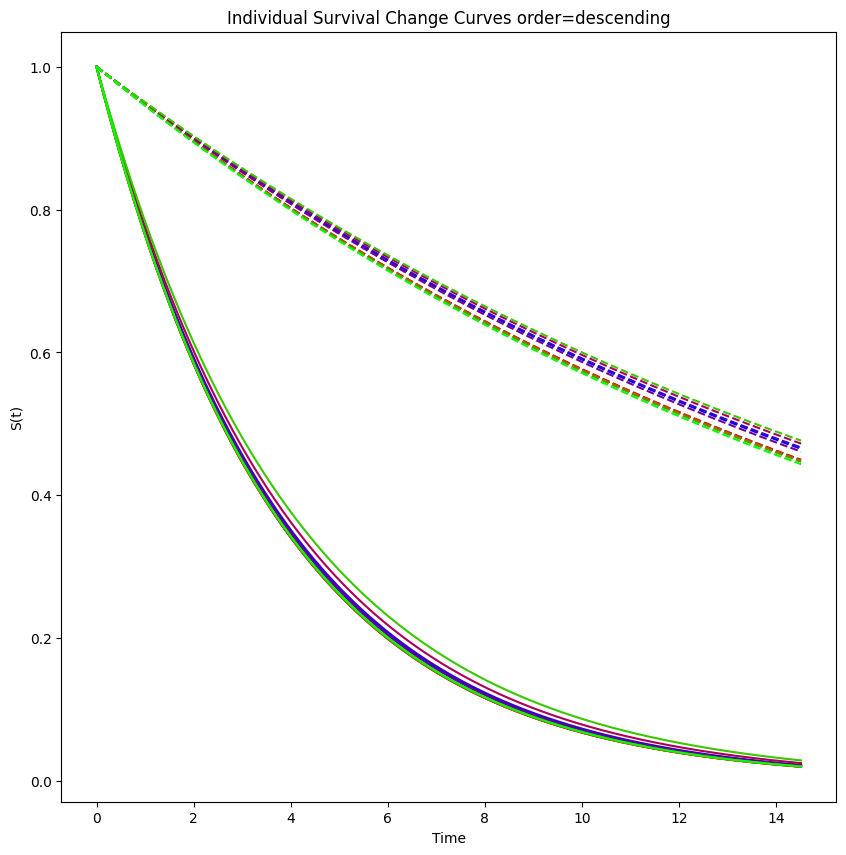

In [25]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

tensor([8.1744, 8.1737, 8.1437, 8.1370, 8.1355, 8.1127, 8.1054, 8.1034, 8.0948,
        8.0818])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


tensor([2.6956, 2.6985, 2.6988, 2.7012, 2.7016, 2.7091, 2.7106, 2.7135, 2.7135,
        2.7141])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


tensor([7.5900, 7.5389, 7.4450, 7.4357, 7.4291, 7.3899, 7.3775, 7.3692, 7.3546,
        7.3494])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.12it/s]


tensor([2.7259, 2.7265, 2.7282, 2.7499, 2.7594, 2.7621, 2.7698, 2.7730, 2.8043,
        2.8049])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.08it/s]


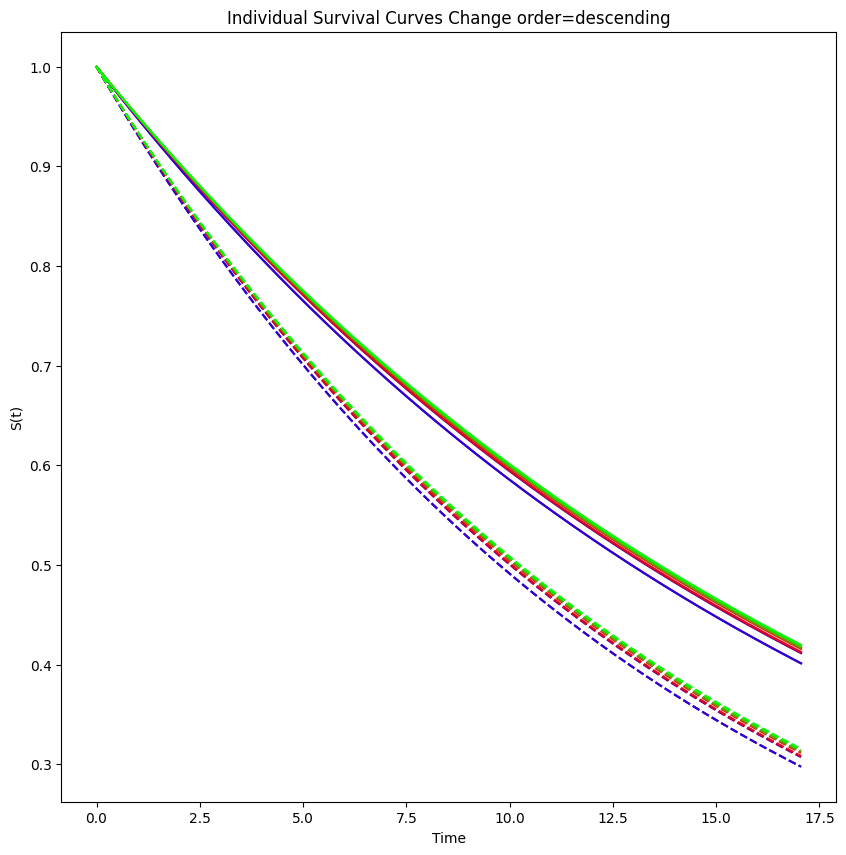

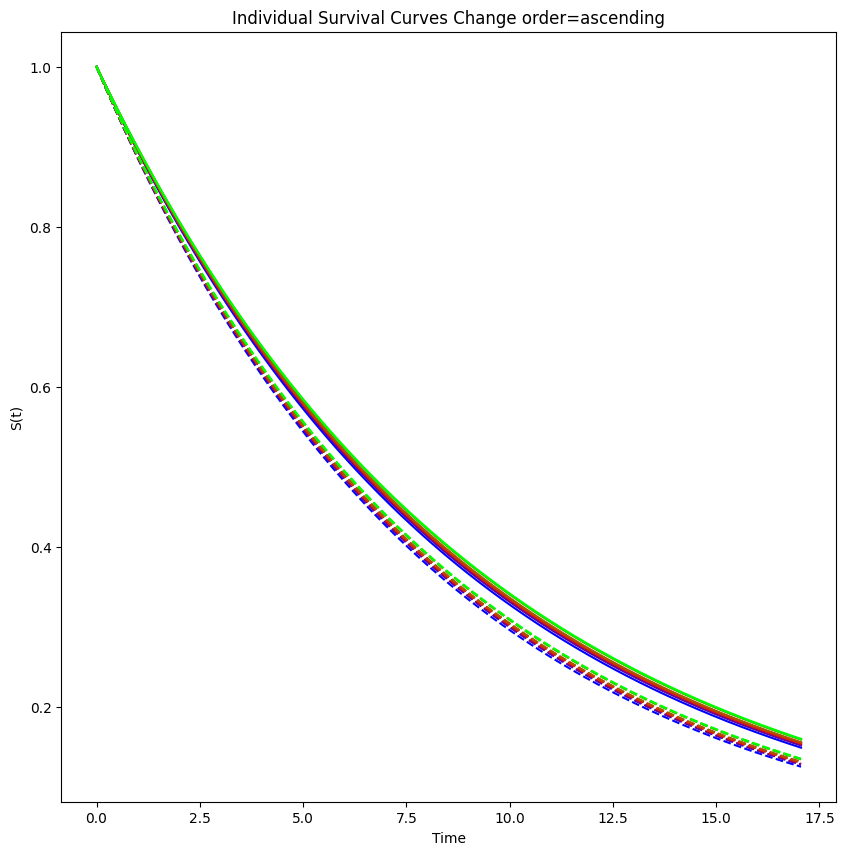

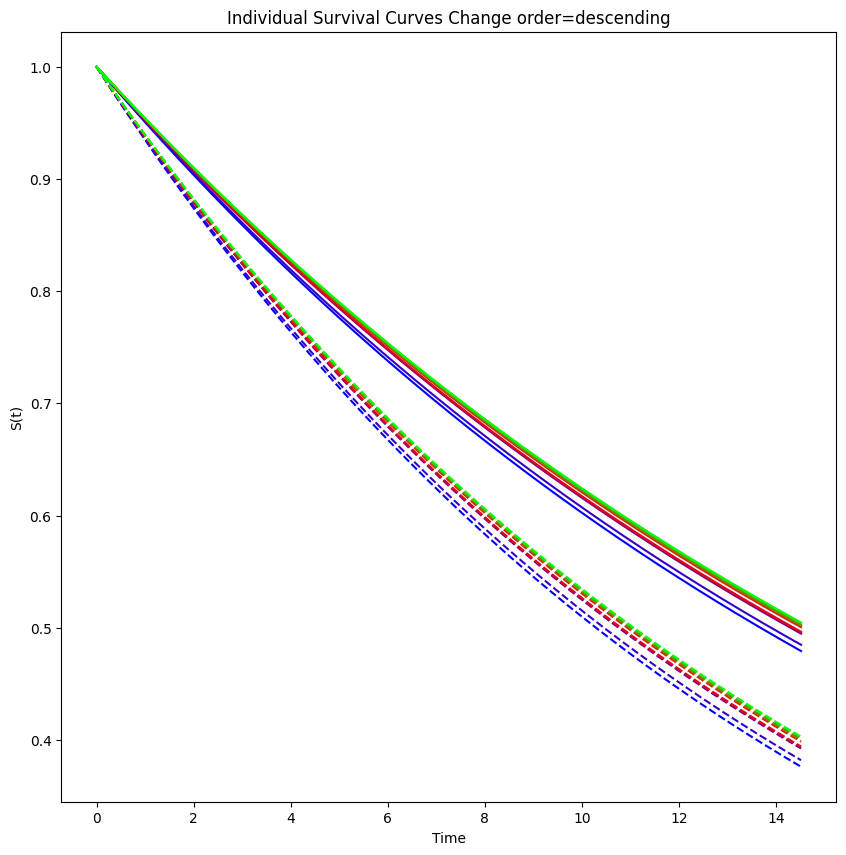

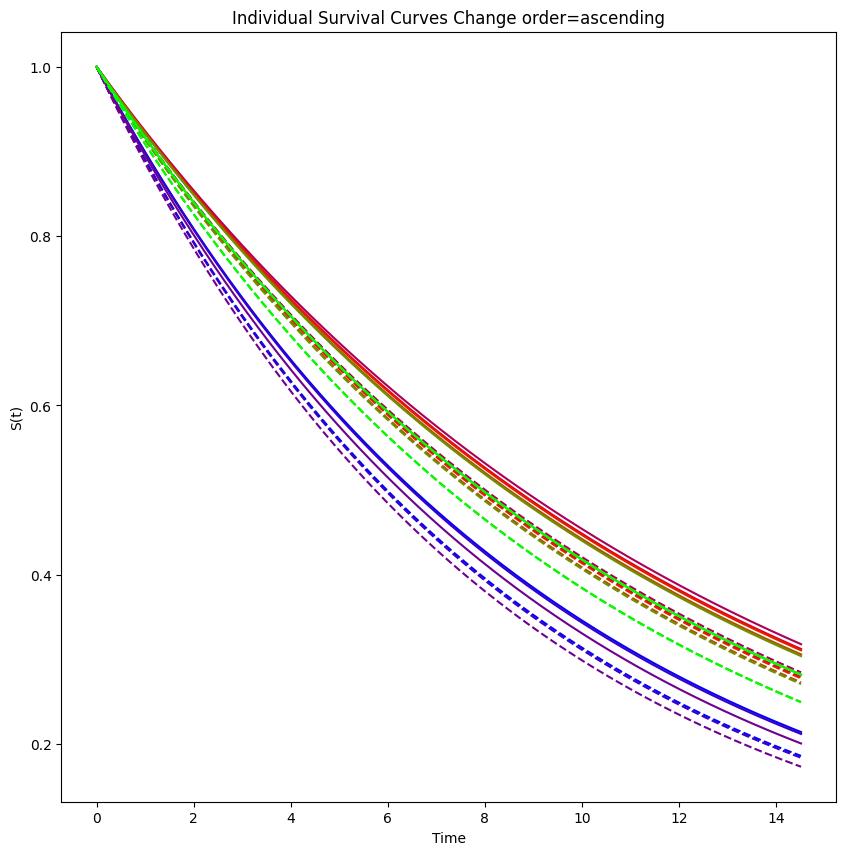

In [26]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")